# ASCAD analysis

## Using hamming weights as key distance measure

For a masked implementation of AES, the XOR operations at the end of the SBox cause the leakage [1].
Splitting the traces in the ASCAD database based on the hamming weight of the state after the SBox operation should
therefore expose this leakage.

[1] Pinpointing the Side-Channel Leakage of Masked AES Hardware Implementations. Mangard S & Schramm K. 2016

### Hamming weight of 1st state byte.

1st order moment difference.

In [142]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import stats

from src.data.slices import make_slice
from src.data.traceloader import AscadRandomKey
from src.data.traceloader import TraceCategory
from src.tools.plotter import shadow_plot
from src.tools.poi import select_poi
from src.tvla.t import make_t_test

In [143]:
sns.set_style("whitegrid")


def random_slice(traces, num_slices, even_slices=True):
    """
    Randomly slices up a given NumPy array.
    """
    total = len(traces)
    if even_slices:
        total -= total % num_slices

    indexes = list(range(total))
    np.random.shuffle(indexes)
    ixs_sliced = np.array_split(indexes, num_slices)

    return np.array([traces[s] for s in ixs_sliced])

In [144]:
ascad = AscadRandomKey()
profile = ascad.default.profile

array([  767,  6221, 22065, 43838, 54996, 43662, 21538,  6129,   784])

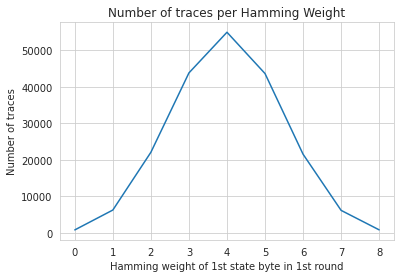

In [145]:
bc = np.bincount(profile.hamming_weights[:,0,0])
sns.lineplot(data=bc).set(title="Number of traces per Hamming Weight",
                          xlabel="Hamming weight of 1st state byte in 1st round",
                          ylabel="Number of traces")

bc

In [146]:

def statistical_moment(traces: np.array, moment=1):
    """
    Retrieves a statistical moment in a given order for a given set of traces.
    The moment
    """
    if moment == 1:
        return traces.mean(axis=0)
    if moment == 2:
        return traces.var(axis=0)
    if moment == 3:
        return stats.skew(traces, axis=0)
    if moment == 4:
        return stats.kurtosis(traces, axis=0)

    raise Exception("Moment not implemented.")


def calc_moment_difference(left_1, left_2, right, moment=1):
    """
    Calculates the difference in statistical moment between power traces with
    equal keys and power traces with different keys.
    """

    def smt(a):
        return statistical_moment(a, moment)

    dist_neq = abs(smt(left_1) - smt(right))
    dist_eq = abs(smt(left_1) - smt(left_2))

    return dist_neq - dist_eq


def hw_mdiff(tc: TraceCategory, trace_size=ascad.trace_len, max_moment=3):
    """
    Calculates the difference in statistical moment between power traces with
    equal keys and power traces with different keys, up to a given order of
    statistical moment.
    """
    mdiff = np.zeros((max_moment + 1, trace_size))
    for stat_moment in range(1, max_moment + 1):
        # TODO 0 vs. rest
        low, high = tc.filter_by_hw(False), tc.filter_by_hw(True)
        low_1, low_2 = random_slice(low, 2)

        mdiff[stat_moment] = calc_moment_difference(low_1, low_2, high, stat_moment)

    return mdiff

In [147]:
def plot_poi(mdiff, moment):
    """
    Plots moment difference with points of interest.
    """
    fig, ax = plt.subplots()

    title = f"Difference in statistical moment ({moment})\n Points of Interest are highlighted.\n"
    sns.lineplot(data=mdiff[moment]).set_title(title)

    for a, b in select_poi(mdiff[moment]):
        ax.axvspan(a, b, alpha=0.3, color=sns.color_palette()[3])

    plt.show()


def plot_poi_trace(trace, poi):
    """
    Plots power trace with points of interest.
    """
    fig, ax = plt.subplots()

    title = f"Some power trace, Points of Interest from\nstatistical moment (1) are highlighted.\n"
    sns.lineplot(data=trace, palette=[sns.color_palette()[4]]).set_title(title)

    for a, b in poi:
        ax.axvspan(a, b, alpha=0.3, color=sns.color_palette()[3])

    plt.show()

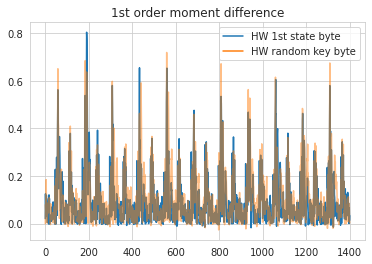

(0.0956122014495805, 0.11047280473950488)

In [148]:
mdiff_default = hw_mdiff(ascad.default.profile, ascad.trace_len)
mdiff_random = hw_mdiff(ascad.random.profile, ascad.trace_len)

shadow_plot({"HW 1st state byte": mdiff_default[1], "HW random key byte": mdiff_random[1]}, title="1st order moment difference")

mdiff_default[1].mean(), mdiff_random[1].mean()

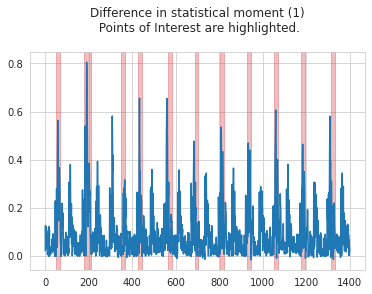

In [149]:
plot_poi(mdiff_default, 1)

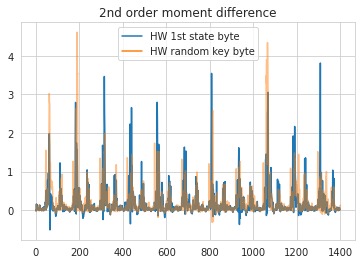

In [150]:
shadow_plot({"HW 1st state byte": mdiff_default[2], "HW random key byte": mdiff_random[2]}, title="2nd order moment difference")

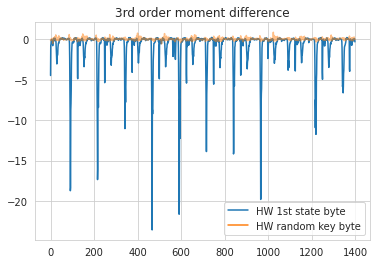

In [151]:
shadow_plot({"HW 1st state byte": mdiff_default[3], "HW random key byte": mdiff_random[3]}, title="3rd order moment difference")

In [152]:
select_poi(mdiff_default[1])

array([[ 179,  208],
       [1051, 1071],
       [ 803,  821],
       [ 563,  583],
       [1314, 1330],
       [ 929,  945],
       [ 350,  367],
       [ 425,  444],
       [  49,   69],
       [1175, 1194],
       [ 689,  704]])

In [153]:
PT_OF_INTEREST = (57, 72)

def prepare(make_test, samples, poi=(None,None)):
    target = samples.filter_by_hw(True)
    rest = samples.filter_by_hw(False)

    slc_target = make_slice(target)
    slc_rest = make_slice(rest)

    def means(slc):
        return np.array([(s.mean(axis=0), s.var(axis=0)) for s in slc], dtype=np.float128)

    slc_mv = np.moveaxis(np.array([means(slc_target), means(slc_rest)]), 2, 3)
    test = make_test(slc_mv.shape[2])

    return test, slc_mv

default_test, default_slices = prepare(make_t_test, ascad.default.profile)
random_test, random_slices = prepare(make_t_test, ascad.random.profile)

/home/berg/Documents/Afstudeer/LA/src/data/slices.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([traces[s] for s in np.array_split(select, 4)])


In [160]:

def device_fails(left: np.array, right: np.array, p: float):
    return np.array((left < p, left < p)).any()


def tvla(test, left, right, p=.01, debug=False):
    """
    Applies some given statistical test against the given samples.

    @param test: statistical test function that takes two samples and returns test values.
    @param left: Four sample sets containing s samples representing a power trace of length t.
    @param right: Two sample sets containing s samples representing a power trace of length t.
    @param p: Decide whether a device fails using (100 * p)%-confidence interval.
    @param debug: Set to True if this function should throw Exceptions upon improperly structured input.
    @return: Whether the device fails on (A against A, A against B).
    """
    if debug:
        assert len(left) == 4
        assert len(right) == 4

    # Four different samples from distribution A.
    a, b, c, d = left
    # Two different samples from distribution B. x and y are compared to a and b, respectively.
    _, _, x, y = right

    # Test A against A.
    aa1 = test(a, c)
    aa2 = test(b, d)

    # Test A against B.
    ab1 = test(a, x)
    ab2 = test(b, y)

    if debug:
        print("Median p-value, A vs. A: ", np.median((aa1, aa2)))
        print("Median p-value, A vs. B: ", np.median((ab1, ab2)))

    # This value for t lets p% of the devices fail.
    return device_fails(aa1, aa2, p), device_fails(ab1, ab2, p)

P_VALUE = .00000000000000001

print(f"p-value: {P_VALUE}")
print()
print("Default TVLA:", tvla(default_test, default_slices[0], default_slices[1], p=P_VALUE, debug=True))
print()
print("Random TVLA:", tvla(random_test, random_slices[0], random_slices[1], p=P_VALUE, debug=True))

p-value: 1e-17

Median p-value, A vs. A:  0.020538386751325258
Median p-value, A vs. B:  0.08103246428429059
Default TVLA: (True, False)

Median p-value, A vs. A:  0.10325218159725891
Median p-value, A vs. B:  0.20333058018582317
Random TVLA: (False, False)


In [155]:
def encode_tvla(test, slices, p):
    res = tvla(test, slices[0], slices[1], p)
    return res[0] * 2 + res[1]

encode_tvla(default_test, default_slices, P_VALUE)

2

In [156]:
def gen_line_ct(test, slices, p_space):
    return [encode_tvla(test, slices, pv) for pv in np.linspace(.001, 0, 50)]